# Example BGS Spectra from One-Percent Survey

In [1]:
import os
import sv as SV
import numpy as np
import astropy.table as atable

import redrock
import redrock.templates
import redrock.results

from desispec.io import read_spectra
from desitarget.sv3.sv3_targetmask import bgs_mask as sv3_bgs_mask

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.use('Agg')
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
templates_path = redrock.templates.find_templates(None)
rr_templates = {}
for el in templates_path:
    t = redrock.templates.Template(filename=el)
    rr_templates[t.full_type] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20211217-2.0.0/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


In [4]:
fuji_exps = SV.info_exposures(release='fuji')
guad_exps = SV.info_exposures(release='guadalupe') 

In [5]:
in_bright = (fuji_exps['FAPRGRM'] == 'bgsmws') | (fuji_exps['FAPRGRM'] == 'bright')
print("%i exposures in BRIGHT" % np.sum(in_bright))
sv3_exps = fuji_exps[(fuji_exps['SURVEY'] == 'sv3') & in_bright]
print('%i SV3 BRIGHT exposure' % len(sv3_exps))

897 exposures in BRIGHT
288 SV3 BRIGHT exposure


In [6]:
# load compiled zsuccess rates to file
dat_dir = '/global/cscratch1/sd/chahah/bgs-cmxsv/sv-paper/'

#sv1_gals = atable.Table.read(os.path.join(dat_dir, 'sv1.bgs_exps.efftime160_200.zsuccess.fuji.fits'))
sv3_gals = atable.Table.read(os.path.join(dat_dir, 'sv3.bgs_exps.efftime160_200.zsuccess.fuji.fits'))
#main_gals = atable.Table.read(os.path.join(dat_dir, 'main.bgs_exps.efftime160_200.zsuccess.v3.fits'))

In [7]:
sv3_gals[:5]

Z_TRUE,TARGETID,DEEP_NUMEXP,DEEP_EXPTIME,DEEP_TSNR2_BGS,DEEP_TRUE,Z,ZERR,ZWARN,CHI2,COEFF [10],NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,ZSUCCESS,RR_ZWARN,RR_DELTACHI2,RR_SPECTYPE,RR_ZERR,RR_Z,RR_Z_DEEP,EXPID,GMAG_DRED,RMAG_DRED,FIBER_RMAG_DRED,ZMAG_DRED,W1MAG_DRED,W2MAG_DRED,FAINT_FIBCOL,EFFTIME_SPEC,DEEP_EFFTIME_SPEC,SURVEY_SPEED,EFFTIME_ETC,ETC_SURVEY_SPEED
float64,int64,int16,float32,float32,bool,float64,float64,int64,float64,float64,int64,bytes6,bytes20,int64,float64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int64,float64,bytes6,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32
0.07777937216262566,39627751551927574,2,1007.7563,2304.8057,True,0.0777835161191793,6.723634863923742e-06,0,8137.060635402799,558.4959018438403 .. 12.044595689590196,7873,GALAXY,--,10,517.5170710533857,1,417,1417,500,0,182.55632632143863,-1.3780918631807284,0.0,0.0,2015.5,5400.0,1152921504606846976,1,TGT,139.2888,-379.83682,102100,0.9067837874882217,516,9010,1826m015,322458,1302,SER,0.019259246,10.988338,16.706974,22.051287,6.2602177,-2.86036,100.7889,49.290077,12.531658,1.3781968,0.2973808,2.2115772,3.3625429,4.4381704,2.2119832,3.36349,4.4398055,0,6.0,4.018671,-0.10134651,-0.42885458,0,--,0.0,0.0,0.0,0.0,S,102100,9,1152921504606846976,131074,0,0,0,0,0,182.55632632143863,-1.3780918631807284,66,1,572.255,1,1,-0.001,0.001,0.001,0.001,182.55632251473406,0.0,-1.378095431121128,0.0,0.7240783,139.237,-379.755,20.788517,0.008394888,4.175302,4.4886675,53.545322,34.99997,0.21754342,0.10155707,1510.1138,3.6202452,291.49396,0.0042808126,314.09378,2147.0806,1.0249641,5.066993,3.1945856e-06,11.224265,6.288779e-07,0.0,618.33905,4.931991e-06,2.4547005,5.6678476,1530.9023,14.852905,295.66925,4.4929485,985.97815,2182.0806,3.697208,10.836398,True,0,517.5170710533857,GALA

In [8]:
sv3_gmag = sv3_gals['GMAG_DRED']
sv3_rmag = sv3_gals['RMAG_DRED']
sv3_zmag = sv3_gals['ZMAG_DRED']
sv3_rfib = sv3_gals['FIBER_RMAG_DRED']
sv3_colr = sv3_gals['FAINT_FIBCOL']

sv3_brgt = (sv3_gals['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_BRIGHT']) != 0 
sv3_fain = (sv3_gals['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_FAINT']) != 0

In [9]:
def get_spectra(tileid, expid, petal, targetid, release='fuji'):
    fspec = os.path.join('/global/cfs/cdirs/desi/spectro/redux/%s/tiles/perexp/%i/%s/' % (release, tileid, str(expid).zfill(8)), 
                         'spectra-%i-%i-exp%s.fits' % (petal, tileid, str(expid).zfill(8)))
    print(fspec)
    from desispec.io import read_spectra
    spec = read_spectra(fspec) 
    
    ifiber = np.arange(500)[spec.target_ids() == targetid][0]
    
    wave = np.concatenate([spec.wave['b'], spec.wave['r'], spec.wave['z']])
    flux = np.concatenate([spec.flux['b'][ifiber].flatten(), spec.flux['r'][ifiber].flatten(), spec.flux['z'][ifiber].flatten()])
    ivar = np.concatenate([spec.ivar['b'][ifiber].flatten(), spec.ivar['r'][ifiber].flatten(), spec.ivar['z'][ifiber].flatten()])
    wsort = np.argsort(wave)

    frr = os.path.join('/global/cfs/cdirs/desi/spectro/redux/%s/tiles/perexp/%i/%s/' % (release, tileid, str(expid).zfill(8)), 
                         'rrdetails-%i-%i-exp%s.h5' % (petal, tileid, str(expid).zfill(8)))
    zscan, zfit = redrock.results.read_zscan(frr) 

    zfit = zfit[zfit['targetid'] == targetid]
    zz = zfit[zfit['znum'] == 0][0] # best-fit 
    coeff = zz['coeff'] 
    fulltype = zz['spectype']
    tp = rr_templates[fulltype]
    bfs = []
    for arm in ['b', 'r', 'z']: 
        mx = tp.eval(coeff[0:tp.nbasis], spec.wave[arm], zz['z']) * (1+zz['z'])
        res = spec.R[arm][ifiber]
        bfs.append(res.dot(mx))
    bfs = np.concatenate(bfs)
    return  wave[wsort], flux[wsort], bfs[wsort], ivar[wsort]

In [10]:
# BGS bright blue
igal0 = [116742] #np.random.choice(np.arange(len(sv3_gals))[sv3_brgt & (sv3_rmag < 18) & ((sv3_gmag - sv3_rmag) < 0.5) & ((sv3_rmag - sv3_zmag) < 0.5) & sv3_gals['ZSUCCESS']], 1)
# BGS bright red
igal1 = np.random.choice(np.arange(len(sv3_gals))[sv3_brgt & (sv3_rmag < 19) & ((sv3_gmag - sv3_rmag) > 0.5) & ((sv3_rmag - sv3_zmag) > 1.) & sv3_gals['ZSUCCESS']], 1)
print(igal0, igal1)

[116742] [79346]


In [11]:
# BGS faint blue
igal2 = [166283] #np.random.choice(np.arange(len(sv3_gals))[sv3_fain & ((sv3_gmag - sv3_rmag) < 0.5) & ((sv3_rmag - sv3_zmag) < 0.5) & sv3_gals['ZSUCCESS']], 1)
# BGS faint red
igal3 = np.random.choice(np.arange(len(sv3_gals))[sv3_fain & ((sv3_gmag - sv3_rmag) > 0.5) & ((sv3_rmag - sv3_zmag) > 1.) & sv3_gals['ZSUCCESS']], 1)
print(igal2, igal3)

[166283] [227880]


In [12]:
def _trapz_rebin(x, y, edges, results):
    '''
    Numba-friendly version of trapezoidal rebinning
    See redrock.rebin.trapz_rebin() for input descriptions.
    `results` is pre-allocated array of length len(edges)-1 to keep results
    '''
    nbin = len(edges) - 1
    i = 0  #- index counter for output
    j = 0  #- index counter for inputs
    yedge = 0.0
    area = 0.0

    while i < nbin:
        #- Seek next sample beyond bin edge
        while x[j] <= edges[i]:
            j += 1

        #- What is the y value where the interpolation crossed the edge?
        yedge = y[j-1] + (edges[i]-x[j-1]) * (y[j]-y[j-1]) / (x[j]-x[j-1])

        #- Is this sample inside this bin?
        if x[j] < edges[i+1]:
            area = 0.5 * (y[j] + yedge) * (x[j] - edges[i])
            results[i] += area

            #- Continue with interior bins
            while x[j+1] < edges[i+1]:
                j += 1
                area = 0.5 * (y[j] + y[j-1]) * (x[j] - x[j-1])
                results[i] += area

            #- Next sample will be outside this bin; handle upper edge
            yedge = y[j] + (edges[i+1]-x[j]) * (y[j+1]-y[j]) / (x[j+1]-x[j])
            area = 0.5 * (yedge + y[j]) * (edges[i+1] - x[j])
            results[i] += area

        #- Otherwise the samples span over this bin
        else:
            ylo = y[j] + (edges[i]-x[j]) * (y[j] - y[j-1]) / (x[j] - x[j-1])
            yhi = y[j] + (edges[i+1]-x[j]) * (y[j] - y[j-1]) / (x[j] - x[j-1])
            area = 0.5 * (ylo+yhi) * (edges[i+1]-edges[i])
            results[i] += area

        i += 1

    for i in range(nbin):
        results[i] /= edges[i+1] - edges[i]

    return

def trapz_rebin(x, y, xnew=None, edges=None):
    """Rebin y(x) flux density using trapezoidal integration between bin edges
    Notes:
        y is interpreted as a density, as is the output, e.g.
        >>> x = np.arange(10)
        >>> y = np.ones(10)
        >>> trapz_rebin(x, y, edges=[0,2,4,6,8])  #- density still 1, not 2
        array([ 1.,  1.,  1.,  1.])
    Args:
        x (array): input x values.
        y (array): input y values.
        edges (array): (optional) new bin edges.
    Returns:
        array: integrated results with len(results) = len(edges)-1
    Raises:
        ValueError: if edges are outside the range of x or if len(x) != len(y)
    """
    if edges is None:
        edges = centers2edges(xnew)
    else:
        edges = np.asarray(edges)

    if edges[0] < x[0] or x[-1] < edges[-1]:
        raise ValueError('edges must be within input x range')

    result = np.zeros(len(edges)-1, dtype=np.float64)

    _trapz_rebin(x, y, edges, result)

    return result

def centers2edges(centers):
    """Convert bin centers to bin edges, guessing at what you probably meant
    Args:
        centers (array): bin centers,
    Returns:
        array: bin edges, lenth = len(centers) + 1
    """
    centers = np.asarray(centers)
    edges = np.zeros(len(centers)+1)
    #- Interior edges are just points half way between bin centers
    edges[1:-1] = (centers[0:-1] + centers[1:]) / 2.0
    #- edge edges are extrapolation of interior bin sizes
    edges[0] = centers[0] - (centers[1]-edges[1])
    edges[-1] = centers[-1] + (centers[-1]-edges[-2])

    return edges

/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/perexp/369/00085637/spectra-7-369-exp00085637.fits
INFO:spectra.py:285:read_spectra: iotime 1.557 sec to read spectra-7-369-exp00085637.fits at 2022-03-10T13:16:58.384395


/tmp/ipykernel_1732/45846844.py:12: RuntimeWarning: divide by zero encountered in power
  sub.plot(w_bgs, i_bgs**-0.5, c='C1', lw=0.5, alpha=0.2)


/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/perexp/229/00085205/spectra-6-229-exp00085205.fits
INFO:spectra.py:285:read_spectra: iotime 1.442 sec to read spectra-6-229-exp00085205.fits at 2022-03-10T13:17:13.547534


/tmp/ipykernel_1732/45846844.py:28: RuntimeWarning: divide by zero encountered in power
  sub.plot(w_bgs, i_bgs**-0.5, c='C1', lw=0.5, alpha=0.2)


/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/perexp/74/00087469/spectra-7-74-exp00087469.fits
INFO:spectra.py:285:read_spectra: iotime 1.245 sec to read spectra-7-74-exp00087469.fits at 2022-03-10T13:17:28.095787


/tmp/ipykernel_1732/45846844.py:43: RuntimeWarning: divide by zero encountered in power
  sub.plot(w_bgs, i_bgs**-0.5, c='C1', lw=0.5, alpha=0.2)


/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/perexp/591/00087714/spectra-3-591-exp00087714.fits
INFO:spectra.py:285:read_spectra: iotime 1.084 sec to read spectra-3-591-exp00087714.fits at 2022-03-10T13:17:42.759898


/tmp/ipykernel_1732/45846844.py:59: RuntimeWarning: divide by zero encountered in power
  sub.plot(w_bgs, i_bgs**-0.5, c='C1', alpha=0.2)


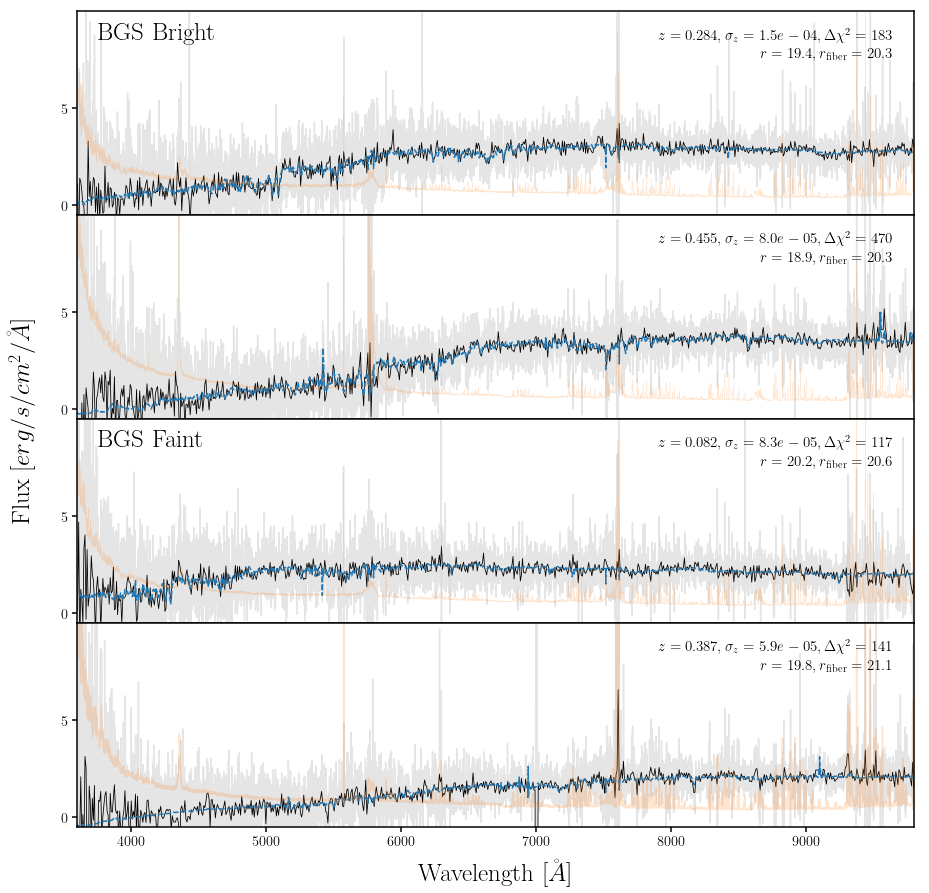

In [16]:
w_coarse = np.linspace(3600., 9824., 800)[1:-1]

fig = plt.figure(figsize=(15,15))

ginfo = sv3_gals[igal0]['TILEID', 'EXPID', 'PETAL_LOC', 'TARGETID']
w_bgs, f_bgs, f_bf, i_bgs = get_spectra(ginfo[0][0], ginfo[0][1], ginfo[0][2], ginfo[0][3])

sub = fig.add_subplot(411)
sub.plot(w_bgs, f_bgs, c='k', alpha=0.1)
sub.plot(w_coarse, trapz_rebin(w_bgs, f_bgs, xnew=w_coarse), c='k', lw=0.8)
sub.plot(w_bgs, f_bf, c='C0', ls='--')
sub.plot(w_bgs, i_bgs**-0.5, c='C1', lw=0.5, alpha=0.2)
sub.text(0.025, 0.95, 'BGS Bright', ha='left', va='top', transform=sub.transAxes, fontsize=25)
sub.text(0.975, 0.925, r'$z=%.3f, \sigma_z=%.1e, \Delta \chi^2=%.f$' % (sv3_gals[igal0]['Z'], sv3_gals[igal0]['ZERR'], sv3_gals[igal0]['RR_DELTACHI2']), ha='right', va='top', transform=sub.transAxes, fontsize=15)
sub.text(0.975, 0.825, r'$r=%.1f, r_{\rm fiber}=%.1f$' % (sv3_rmag[igal0], sv3_rfib[igal0]), ha='right', va='top', transform=sub.transAxes, fontsize=15)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_xticklabels([])
sub.set_ylim(-0.5, 10)
sub.set_yticks([0., 5.])

ginfo = sv3_gals[igal1]['TILEID', 'EXPID', 'PETAL_LOC', 'TARGETID']
w_bgs, f_bgs, f_bf, i_bgs = get_spectra(ginfo[0][0], ginfo[0][1], ginfo[0][2], ginfo[0][3])

sub = fig.add_subplot(412)
sub.plot(w_bgs, f_bgs, c='k', alpha=0.1)
sub.plot(w_coarse, trapz_rebin(w_bgs, f_bgs, xnew=w_coarse), c='k', lw=0.8)
sub.plot(w_bgs, f_bf, c='C0', ls='--')
sub.plot(w_bgs, i_bgs**-0.5, c='C1', lw=0.5, alpha=0.2)
sub.text(0.975, 0.925, r'$z=%.3f, \sigma_z=%.1e, \Delta \chi^2=%.f$' % (sv3_gals[igal1]['Z'], sv3_gals[igal1]['ZERR'], sv3_gals[igal1]['RR_DELTACHI2']), ha='right', va='top', transform=sub.transAxes, fontsize=15)
sub.text(0.975, 0.825, r'$r=%.1f, r_{\rm fiber}=%.1f$' % (sv3_rmag[igal1], sv3_rfib[igal1]), ha='right', va='top', transform=sub.transAxes, fontsize=15)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_xticklabels([])
sub.set_ylim(-0.5, 10)
sub.set_yticks([0., 5.])

ginfo = sv3_gals[igal2]['TILEID', 'EXPID', 'PETAL_LOC', 'TARGETID']
w_bgs, f_bgs, f_bf, i_bgs = get_spectra(ginfo[0][0], ginfo[0][1], ginfo[0][2], ginfo[0][3])

sub = fig.add_subplot(413)
sub.plot(w_bgs, f_bgs, c='k', alpha=0.1)
sub.plot(w_coarse, trapz_rebin(w_bgs, f_bgs, xnew=w_coarse), c='k', lw=0.8)
sub.plot(w_bgs, f_bf, c='C0', ls='--')
sub.plot(w_bgs, i_bgs**-0.5, c='C1', lw=0.5, alpha=0.2)
sub.text(0.025, 0.95, 'BGS Faint', ha='left', va='top', transform=sub.transAxes, fontsize=25)
sub.text(0.975, 0.925, r'$z=%.3f, \sigma_z=%.1e, \Delta \chi^2=%.f$' % (sv3_gals[igal2]['Z'], sv3_gals[igal2]['ZERR'], sv3_gals[igal2]['RR_DELTACHI2']), ha='right', va='top', transform=sub.transAxes, fontsize=15)
sub.text(0.975, 0.825, r'$r=%.1f, r_{\rm fiber}=%.1f$' % (sv3_rmag[igal2], sv3_rfib[igal2]), ha='right', va='top', transform=sub.transAxes, fontsize=15)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_xticklabels([])
sub.set_ylim(-0.5, 10)
sub.set_yticks([0., 5.])

ginfo = sv3_gals[igal3]['TILEID', 'EXPID', 'PETAL_LOC', 'TARGETID']
w_bgs, f_bgs, f_bf, i_bgs = get_spectra(ginfo[0][0], ginfo[0][1], ginfo[0][2], ginfo[0][3])

sub = fig.add_subplot(414)
sub.plot(w_bgs, f_bgs, c='k', alpha=0.1)
sub.plot(w_coarse, trapz_rebin(w_bgs, f_bgs, xnew=w_coarse), c='k', lw=0.8)
sub.plot(w_bgs, f_bf, c='C0', ls='--')
sub.plot(w_bgs, i_bgs**-0.5, c='C1', alpha=0.2)

sub.text(0.975, 0.925, r'$z=%.3f, \sigma_z=%.1e, \Delta \chi^2=%.f$' % (sv3_gals[igal3]['Z'], sv3_gals[igal3]['ZERR'], sv3_gals[igal3]['RR_DELTACHI2']), ha='right', va='top', transform=sub.transAxes, fontsize=15)
sub.text(0.975, 0.825, r'$r=%.1f, r_{\rm fiber}=%.1f$' % (sv3_rmag[igal3], sv3_rfib[igal3]), ha='right', va='top', transform=sub.transAxes, fontsize=15)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylim(-0.5, 10)
sub.set_yticks([0., 5.])

bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('Wavelength [$\AA$]', labelpad=10, fontsize=25) 
bkgd.set_ylabel(r'Flux [$erg/s/cm^2/\AA$]', labelpad=15, fontsize=25)
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

fig.subplots_adjust(wspace=0.1, hspace=0.0)
fig.savefig('figs/bgs_spectra.pdf', bbox_inches='tight')

In [15]:
ws_bgs = np.zeros((4, len(w_bgs)))
fs_bgs = np.zeros((4, len(w_bgs)))                                    
is_bgs = np.zeros((4, len(w_bgs)))
fs_bf = np.zeros((4, len(w_bgs)))

for i, _igal in enumerate([igal0, igal1, igal2, igal3]): 
    ginfo = sv3_gals[_igal]['TILEID', 'EXPID', 'PETAL_LOC', 'TARGETID']
    w_bgs, f_bgs, f_bf, i_bgs = get_spectra(ginfo[0][0], ginfo[0][1], ginfo[0][2], ginfo[0][3])

    ws_bgs[i,:] = w_bgs
    fs_bgs[i,:] = f_bgs
    is_bgs[i,:] = i_bgs
    fs_bf[i,:] = f_bf
    
import h5py
f = h5py.File('dat/fig7_spectra.hdf5', 'w')
f.create_dataset('wavelength', data=ws_bgs)
f.create_dataset('flux', data=fs_bgs)
f.create_dataset('ivar', data=is_bgs)
f.create_dataset('bestfit', data=fs_bf)
f.close()

/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/perexp/369/00085637/spectra-7-369-exp00085637.fits
INFO:spectra.py:285:read_spectra: iotime 1.109 sec to read spectra-7-369-exp00085637.fits at 2022-03-09T09:44:13.081322
/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/perexp/530/00087706/spectra-8-530-exp00087706.fits
INFO:spectra.py:285:read_spectra: iotime 1.071 sec to read spectra-8-530-exp00087706.fits at 2022-03-09T09:44:26.026953
/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/perexp/74/00087469/spectra-7-74-exp00087469.fits
INFO:spectra.py:285:read_spectra: iotime 0.934 sec to read spectra-7-74-exp00087469.fits at 2022-03-09T09:44:38.349347
/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/perexp/66/00083527/spectra-4-66-exp00083527.fits
INFO:spectra.py:285:read_spectra: iotime 0.914 sec to read spectra-4-66-exp00083527.fits at 2022-03-09T09:44:50.113220
